This notebook uses the **SUBTLEX-CH corpus** for Chinese word frequencies:
- **Source**: [SUBTLEX-CH Database](http://www.ugent.be/pp/experimentele-psychologie/en/research/documents/subtlexch)
- **Files needed** (if regenerating from scratch):
  - `SUBTLEX-CH-WF_PoS.xlsx` - Word forms with part-of-speech tags

The raw SUBTLEX `.xlsx` files are not tracked in git due to size and licensing.
However, the processed `nouns_top2500.csv` **is tracked**, so you can run the analysis
immediately after cloning without downloading the source files.

**To regenerate from scratch**:
1. Download SUBTLEX-CH files from the link above
2. Place `SUBTLEX-CH-WF_PoS.xlsx` in the `data/` directory
3. Delete `data/nouns_top2500.csv`
4. Run the cells below

## Data Preparation

### Load Data

In [11]:
import pandas as pd
import os

# Load from existing CSV if available
if os.path.exists('data/nouns_top2500.csv'):
    print("Loading existing nouns_top2500.csv...")
    df_noun_top2500 = pd.read_csv('data/nouns_top2500.csv')
else:
    # Process from source XLSX file
    print("Processing SUBTLEX-CH-WF_PoS.xlsx to create nouns_top2500.csv...")
    df_pos = pd.read_excel('data/SUBTLEX-CH-WF_PoS.xlsx', skiprows=2)
    df_pos.columns = ['Lemma', 'WF_Lemma', 'WordForm', 'PoS', 'WF_PoS']

    df_noun = df_pos[df_pos['PoS'] == 'n']
    df_noun = df_noun.drop(columns=['PoS', 'Lemma', 'WF_Lemma'])
    df_noun = df_noun.sort_values('WF_PoS', ascending=False)

    df_noun_top2500 = df_noun.head(2500)
    df_noun_top2500 = df_noun_top2500.rename(columns={'WordForm': 'Noun'})
    df_noun_top2500 = df_noun_top2500.rename(columns={'WF_PoS': 'Frequency'})
    
    df_noun_top2500.to_csv('data/nouns_top2500.csv', index=False)
    print("Created and saved nouns_top2500.csv")

print(f"Loaded {len(df_noun_top2500)} nouns")

Loading existing nouns_top2500.csv...
Loaded 2500 nouns


### Add Translation

In [12]:
from deep_translator import GoogleTranslator
import time

df_noun_top2500 = pd.read_csv('data/nouns_top2500.csv')
translator = GoogleTranslator(source='zh-CN', target='en')

def get_english_equivalent(word):
    try:
        translation = translator.translate(word)
        return translation.strip().lower()
    except Exception as e:
        print(f"Error translating {word}: {e}")
        return 'N/A'

if 'English' not in df_noun_top2500.columns:
    df_noun_top2500['English'] = ''

translated_count = 0
for i, row in df_noun_top2500.iterrows():

    if pd.notna(row['English']) and row['English'] != '':
        continue
    
    word = row['Noun']
    equivalent = get_english_equivalent(word)
    df_noun_top2500.at[i, 'English'] = equivalent
    translated_count += 1
    
    time.sleep(0.1)

    if translated_count % 100 == 0:
        print(f"Translated {translated_count} words...")

print(f"Total words translated: {translated_count}/{len(df_noun_top2500)}\n")

df_noun_top2500.to_csv('data/nouns_top2500.csv', index=False)
print(df_noun_top2500.head(10))

Total words translated: 0/2500

  Noun  Frequency    English
0    人   194914.0     people
1    事    97710.0      thing
2   时候    52176.0       when
3   先生    46864.0  gentlemen
4    话    39887.0       talk
5   东西    37700.0      thing
6   孩子    37243.0      child
7   问题    33364.0   question
8   时间    30703.0       time
9    钱    29217.0      money


### Create Embeddings    

In [13]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

model_name = "bert-base-chinese"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

model.eval()

nouns = df_noun_top2500['Noun'].tolist()
embeddings = []

for noun in nouns:
    inputs = tokenizer(noun, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    emb = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    embeddings.append(emb)

embeddings = np.stack(embeddings) 

## Clustering Method Comparison

Grid Search for Optimal Number of Clusters (5-30)

Optimal K-means:        7 clusters (silhouette=0.0481)
Optimal Agglomerative:  15 clusters (silhouette=0.0434)


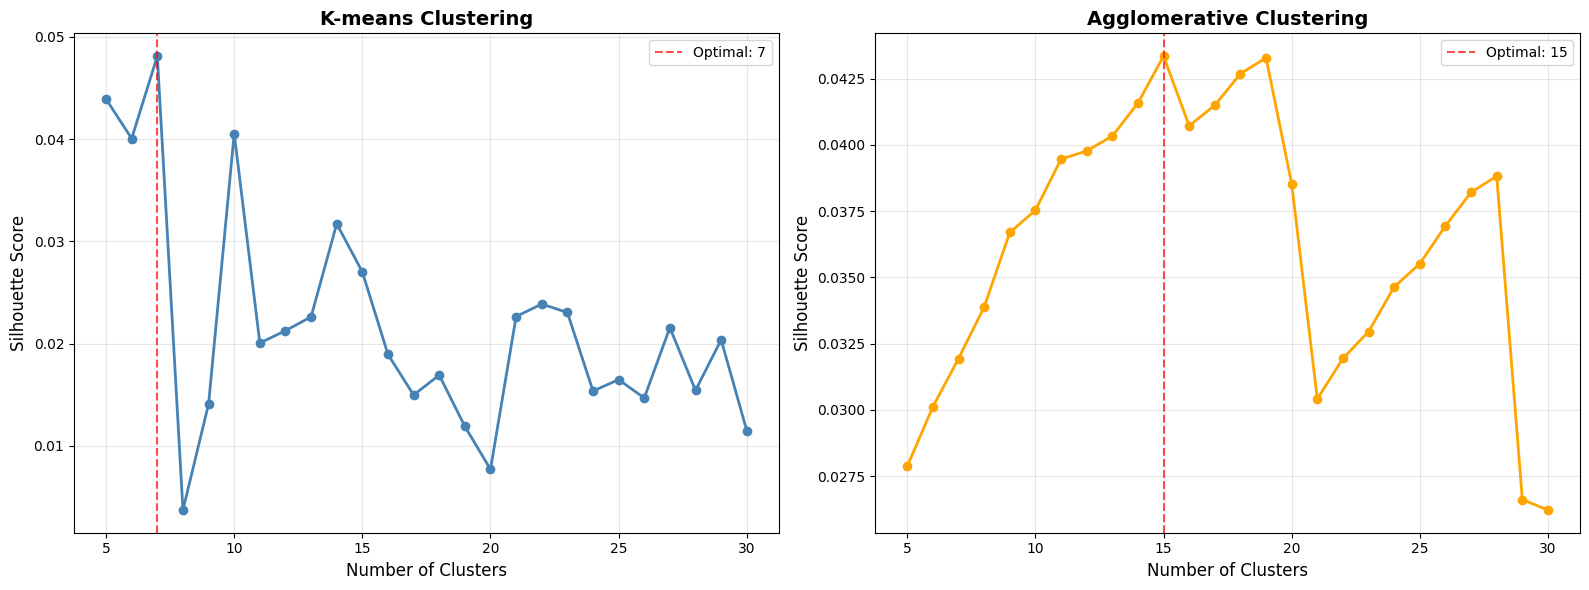


K-MEANS CLUSTERING ANALYSIS (n_clusters=7)

Cluster 0 (size: 67):
  1. 机器     - machine              (freq: 1709)
  2. 女人     - woman                (freq: 14388)
  3. 男人     - man                  (freq: 11608)

Cluster 1 (size: 152):
  1. 技术     - technology           (freq: 2136)
  2. 军队     - army                 (freq: 1870)
  3. 名单     - list                 (freq: 2212)

Cluster 2 (size: 21):
  1. 脑子     - brain                (freq: 2401)
  2. 孩子     - child                (freq: 37243)
  3. 小子     - boy                  (freq: 4818)

Cluster 3 (size: 72):
  1. 话      - talk                 (freq: 39887)
  2. 生命     - life                 (freq: 5898)
  3. 时代     - era                  (freq: 1544)

Cluster 4 (size: 44):
  1. 姑娘     - girl                 (freq: 3765)
  2. 妹妹     - younger sister       (freq: 3262)
  3. 妻子     - wife                 (freq: 6494)

Cluster 5 (size: 30):
  1. 情绪     - mood                 (freq: 1446)
  2. 灵魂     - soul                 (freq: 242

In [ ]:
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Use top 500 embeddings
top_n = 500
embeddings_top500 = embeddings[:top_n]
nouns_top500 = df_noun_top2500.head(top_n)

# Grid search parameters
cluster_range = range(5, 31)  # 5 to 30 clusters

# Store results
agg_scores = []
kmeans_scores = []

print("Grid Search for Optimal Number of Clusters (5-30)")

for n_clusters in cluster_range:
    # Agglomerative
    agg = AgglomerativeClustering(n_clusters=n_clusters)
    agg_labels = agg.fit_predict(embeddings_top500)
    agg_silhouette = silhouette_score(embeddings_top500, agg_labels)
    agg_scores.append(agg_silhouette)
    
    # K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(embeddings_top500)
    kmeans_silhouette = silhouette_score(embeddings_top500, kmeans_labels)
    kmeans_scores.append(kmeans_silhouette)

# Find optimal number of clusters for each method
optimal_agg_idx = np.argmax(agg_scores)
optimal_agg_clusters = list(cluster_range)[optimal_agg_idx]

optimal_kmeans_idx = np.argmax(kmeans_scores)
optimal_kmeans_clusters = list(cluster_range)[optimal_kmeans_idx]

print("\n" + "=" * 60)
print(f"Optimal K-means:        {optimal_kmeans_clusters} clusters (silhouette={kmeans_scores[optimal_kmeans_idx]:.4f})")
print(f"Optimal Agglomerative:  {optimal_agg_clusters} clusters (silhouette={agg_scores[optimal_agg_idx]:.4f})")
print("=" * 60)

# Plot silhouette scores - side by side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# K-means plot
ax1.plot(cluster_range, kmeans_scores, marker='o', linewidth=2, markersize=6, color='steelblue')
ax1.axvline(x=optimal_kmeans_clusters, color='r', linestyle='--', alpha=0.7, 
            label=f'Optimal: {optimal_kmeans_clusters}')
ax1.set_xlabel('Number of Clusters', fontsize=12)
ax1.set_ylabel('Silhouette Score', fontsize=12)
ax1.set_title('K-means Clustering', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Agglomerative plot
ax2.plot(cluster_range, agg_scores, marker='o', linewidth=2, markersize=6, color='orange')
ax2.axvline(x=optimal_agg_clusters, color='r', linestyle='--', alpha=0.7, 
            label=f'Optimal: {optimal_agg_clusters}')
ax2.set_xlabel('Number of Clusters', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Agglomerative Clustering', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Function to find closest nouns to centroids using KNN
def find_representative_nouns(embeddings, labels, nouns_df, n_clusters, n_representatives=3):
    """Find the n closest nouns to each cluster centroid using KNN"""
    results = []
    
    for cluster_id in range(n_clusters):
        # Get all points in this cluster
        cluster_mask = labels == cluster_id
        cluster_embeddings = embeddings[cluster_mask]
        cluster_nouns = nouns_df[cluster_mask]
        
        # Calculate centroid
        centroid = cluster_embeddings.mean(axis=0).reshape(1, -1)
        
        # Use KNN to find closest nouns to centroid
        knn = NearestNeighbors(n_neighbors=min(n_representatives, len(cluster_embeddings)))
        knn.fit(cluster_embeddings)
        distances, indices = knn.kneighbors(centroid)
        
        # Get the representative nouns
        representative_nouns = cluster_nouns.iloc[indices[0]]
        
        results.append({
            'cluster_id': cluster_id,
            'size': cluster_mask.sum(),
            'representatives': representative_nouns[['Noun', 'English', 'Frequency']].to_dict('records')
        })
    
    return results

# Analyze K-means clusters
print("\n" + "=" * 60)
print(f"K-MEANS CLUSTERING ANALYSIS (n_clusters={optimal_kmeans_clusters})")
print("=" * 60)

kmeans_optimal = KMeans(n_clusters=optimal_kmeans_clusters, random_state=42, n_init=10)
kmeans_optimal_labels = kmeans_optimal.fit_predict(embeddings_top500)

kmeans_results = find_representative_nouns(
    embeddings_top500, 
    kmeans_optimal_labels, 
    nouns_top500, 
    optimal_kmeans_clusters
)

for cluster_info in kmeans_results:
    print(f"\nCluster {cluster_info['cluster_id']} (size: {cluster_info['size']}):")
    for i, rep in enumerate(cluster_info['representatives'], 1):
        print(f"  {i}. {rep['Noun']:6s} - {rep['English']:20s} (freq: {rep['Frequency']:.0f})")

# Analyze Agglomerative clusters
print("\n" + "=" * 60)
print(f"\nAGGLOMERATIVE CLUSTERING ANALYSIS (n_clusters={optimal_agg_clusters})")
print("=" * 60)

agg_optimal = AgglomerativeClustering(n_clusters=optimal_agg_clusters)
agg_optimal_labels = agg_optimal.fit_predict(embeddings_top500)

agg_results = find_representative_nouns(
    embeddings_top500, 
    agg_optimal_labels, 
    nouns_top500, 
    optimal_agg_clusters
)

for cluster_info in agg_results:
    print(f"\nCluster {cluster_info['cluster_id']} (size: {cluster_info['size']}):")
    for i, rep in enumerate(cluster_info['representatives'], 1):
        print(f"  {i}. {rep['Noun']:6s} - {rep['English']:20s} (freq: {rep['Frequency']:.0f})")

print("\n" + "=" * 60)

## PCA Optimisation

### Silhouette Score

PCA Grid Search with 15 Agglomerative Clusters

Optimal PCA: 3 components (silhouette=0.2421)


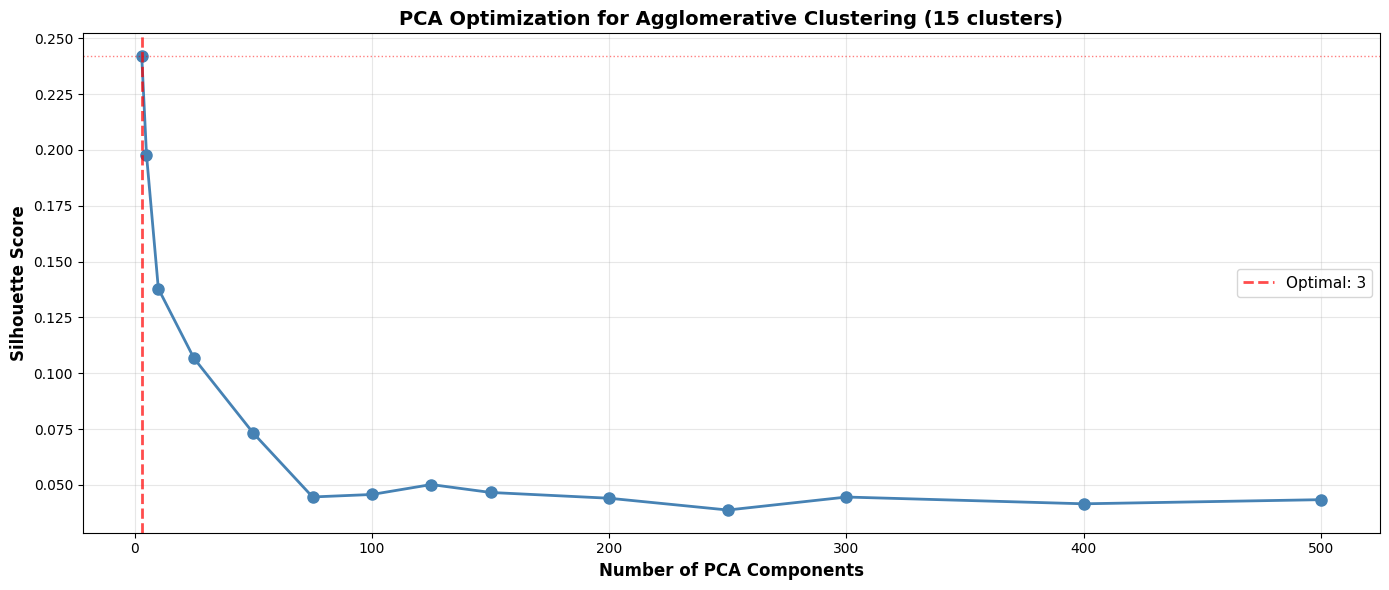


AGGLOMERATIVE CLUSTERING WITH 3 PCA COMPONENTS

Cluster 0 (size: 79):
  1. 炸弹     - bomb                 (freq: 2268)
  2. 报纸     - newspaper            (freq: 1710)
  3. 同志     - comrade              (freq: 1873)

Cluster 4 (size: 60):
  1. 结果     - result               (freq: 6902)
  2. 意思     - mean                 (freq: 19217)
  3. 代价     - cost                 (freq: 1520)

Cluster 6 (size: 55):
  1. 局      - bureau               (freq: 2465)
  2. 头      - head                 (freq: 8664)
  3. 钟      - bell                 (freq: 2477)

Cluster 1 (size: 49):
  1. 电脑     - computer             (freq: 3210)
  2. 无辜     - innocent             (freq: 1449)
  3. 角色     - role                 (freq: 2403)

Cluster 13 (size: 45):
  1. 口      - mouth                (freq: 1953)
  2. 室      - room                 (freq: 2526)
  3. 岛      - island               (freq: 2950)

Cluster 3 (size: 41):
  1. 时光     - time                 (freq: 1700)
  2. 真相     - the truth            (freq: 30

In [15]:
from sklearn.decomposition import PCA

# PCA grid search parameters
pca_components = [3, 5, 10, 25, 50, 75, 100, 125, 150, 200, 250, 300, 400, 500]

# Store results
pca_scores = []
pca_embeddings_dict = {}

print(f"PCA Grid Search with {optimal_agg_clusters} Agglomerative Clusters")

for n_components in pca_components:
    # Apply PCA
    pca = PCA(n_components=n_components, random_state=42)
    embeddings_pca = pca.fit_transform(embeddings_top500)
    
    # Store PCA-transformed embeddings
    pca_embeddings_dict[n_components] = embeddings_pca
    
    # Apply Agglomerative Clustering
    agg = AgglomerativeClustering(n_clusters=optimal_agg_clusters)
    labels = agg.fit_predict(embeddings_pca)
    
    # Calculate silhouette score
    silhouette = silhouette_score(embeddings_pca, labels)
    pca_scores.append(silhouette)

# Find optimal PCA components
optimal_idx = np.argmax(pca_scores)
optimal_pca = pca_components[optimal_idx]
optimal_score = pca_scores[optimal_idx]

print("\n" + "=" * 60)
print(f"Optimal PCA: {optimal_pca} components (silhouette={optimal_score:.4f})")
print("=" * 60)

# Plot silhouette scores vs PCA components
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(pca_components, pca_scores, marker='o', linewidth=2, markersize=8, 
        color='steelblue')
ax.axvline(x=optimal_pca, color='r', linestyle='--', alpha=0.7, linewidth=2,
           label=f'Optimal: {optimal_pca}')
ax.axhline(y=optimal_score, color='r', linestyle=':', alpha=0.5, linewidth=1)

ax.set_xlabel('Number of PCA Components', fontsize=12, fontweight='bold')
ax.set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
ax.set_title(f'PCA Optimization for Agglomerative Clustering ({optimal_agg_clusters} clusters)', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

# Analyze clusters with optimal PCA
print("\n" + "=" * 60)
print(f"AGGLOMERATIVE CLUSTERING WITH {optimal_pca} PCA COMPONENTS")
print("=" * 60)

# Get optimal PCA embeddings
optimal_embeddings = pca_embeddings_dict[optimal_pca]

# Fit optimal clustering
agg_optimal = AgglomerativeClustering(n_clusters=optimal_agg_clusters)
optimal_labels = agg_optimal.fit_predict(optimal_embeddings)

# Find representative nouns using the existing function
optimal_results = find_representative_nouns(
    optimal_embeddings, 
    optimal_labels, 
    nouns_top500, 
    optimal_agg_clusters,
    n_representatives=3
)

# Sort clusters by size (descending) for better readability
optimal_results_sorted = sorted(optimal_results, key=lambda x: x['size'], reverse=True)

for cluster_info in optimal_results_sorted:
    print(f"\nCluster {cluster_info['cluster_id']} (size: {cluster_info['size']}):")
    for i, rep in enumerate(cluster_info['representatives'], 1):
        print(f"  {i}. {rep['Noun']:6s} - {rep['English']:20s} (freq: {rep['Frequency']:.0f})")

print("\n" + "=" * 60)
print(f"\nSummary:")
print(f"  • Best PCA components: {optimal_pca}")
print(f"  • Number of clusters: {optimal_agg_clusters}")
print(f"  • Silhouette score: {optimal_score:.4f}")
print(f"  • Explained variance: {sum(pca.explained_variance_ratio_):.2%}")
print("=" * 60)

---

The PCA grid search above selected **3 components** as optimal based on silhouette score. 

However, this metric has a critical limitation:

**Silhouette scores measure geometric separation, not semantic coherence.**

At very low dimensions, the geometric compression can artificially inflate silhouette scores.

To properly evaluate PCA dimensionality, we need to validate cluster quality **in the original 768-dimensional BERT embedding space** where semantic relationships are preserved.

The enhanced analysis below addresses this by computing:
- **Intra-cluster coherence**: Are cluster members semantically similar in original space?
- **Inter-centroid separation**: Are clusters distinct in original space?
- **Baseline similarity**: Does PCA preserve the natural clustering structure?
- **Reconstruction fidelity**: How much information does PCA lose?

This allows us to distinguish between geometric artifacts and genuine semantic clustering improvements.

---

### Semantic Coherence

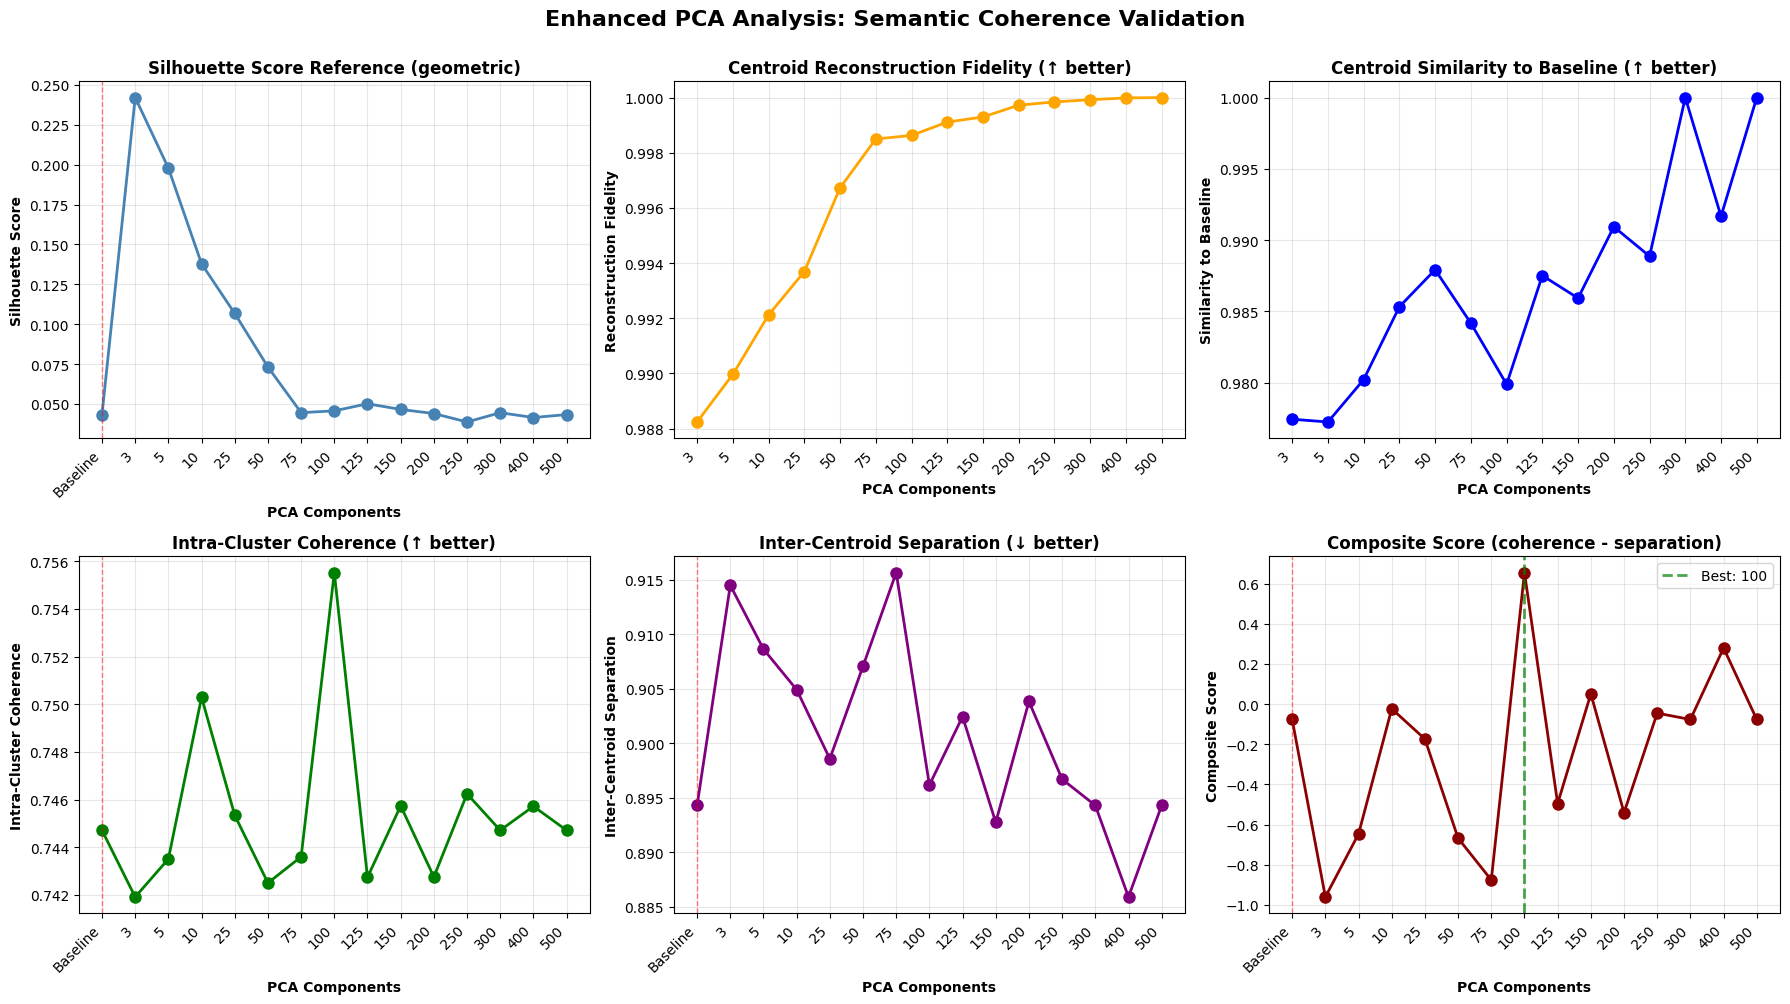

In [16]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute baseline clustering (no PCA) for comparison
agg_baseline = AgglomerativeClustering(n_clusters=optimal_agg_clusters)
baseline_labels = agg_baseline.fit_predict(embeddings_top500)

# Compute baseline centroids in original space
baseline_centroids = []
for i in range(optimal_agg_clusters):
    cluster_mask = baseline_labels == i
    centroid = embeddings_top500[cluster_mask].mean(axis=0)
    baseline_centroids.append(centroid)
baseline_centroids = np.array(baseline_centroids)

# Enhanced metrics function
def compute_enhanced_metrics(embeddings_pca, embeddings_original, labels, n_clusters, 
                              baseline_centroids, pca_transformer=None):
    metrics_list = []
    
    # Compute post-PCA centroids in ORIGINAL space
    pca_centroids_original = []
    for i in range(n_clusters):
        cluster_mask = labels == i
        centroid_original = embeddings_original[cluster_mask].mean(axis=0)
        pca_centroids_original.append(centroid_original)
    pca_centroids_original = np.array(pca_centroids_original)
    
    # Match post-PCA clusters to baseline clusters
    centroid_similarity_matrix = cosine_similarity(pca_centroids_original, baseline_centroids)
    best_matches = centroid_similarity_matrix.argmax(axis=1)
    
    for cluster_id in range(n_clusters):
        cluster_mask = labels == cluster_id
        cluster_members = embeddings_original[cluster_mask]
        n_members = cluster_members.shape[0]
        
        if n_members < 2:
            continue
        
        centroid_original = pca_centroids_original[cluster_id]
        
        # Intra-cluster coherence
        pairwise_sim = cosine_similarity(cluster_members)
        mask = ~np.eye(pairwise_sim.shape[0], dtype=bool)
        intra_coherence = pairwise_sim[mask].mean() if mask.sum() > 0 else 1.0
        
        # Inter-centroid separation
        other_centroids = np.delete(pca_centroids_original, cluster_id, axis=0)
        inter_separation = cosine_similarity(
            centroid_original.reshape(1, -1), 
            other_centroids
        ).mean()
        
        # Baseline similarity
        best_baseline_idx = best_matches[cluster_id]
        baseline_similarity = cosine_similarity(
            centroid_original.reshape(1, -1),
            baseline_centroids[best_baseline_idx].reshape(1, -1)
        )[0, 0]
        
        # Reconstruction fidelity
        if pca_transformer is not None:
            centroid_pca = embeddings_pca[cluster_mask].mean(axis=0)
            centroid_reconstructed = pca_transformer.inverse_transform(
                centroid_pca.reshape(1, -1)
            )[0]
            reconstruction_fidelity = cosine_similarity(
                centroid_original.reshape(1, -1),
                centroid_reconstructed.reshape(1, -1)
            )[0, 0]
        else:
            reconstruction_fidelity = 1.0
        
        metrics_list.append({
            'cluster_id': cluster_id,
            'n_members': n_members,
            'intra_coherence': intra_coherence,
            'inter_separation': inter_separation,
            'baseline_similarity': baseline_similarity,
            'reconstruction_fidelity': reconstruction_fidelity,
            'matched_baseline_cluster': best_baseline_idx
        })
    
    return pd.DataFrame(metrics_list)

# Compute metrics for all PCA levels
pca_summary = []

# Baseline
baseline_metrics_df = compute_enhanced_metrics(
    embeddings_top500, embeddings_top500, baseline_labels, 
    optimal_agg_clusters, baseline_centroids, pca_transformer=None
)
pca_summary.append({
    'pca_components': 'Baseline',
    'mean_intra_coherence': baseline_metrics_df['intra_coherence'].mean(),
    'mean_inter_separation': baseline_metrics_df['inter_separation'].mean(),
    'mean_baseline_similarity': baseline_metrics_df['baseline_similarity'].mean(),
    'mean_reconstruction_fidelity': baseline_metrics_df['reconstruction_fidelity'].mean(),
    'silhouette_score': silhouette_score(embeddings_top500, baseline_labels)
})

# Each PCA level
for i, n_components in enumerate(pca_components):
    pca = PCA(n_components=n_components, random_state=42)
    embeddings_pca = pca.fit_transform(embeddings_top500)
    
    agg = AgglomerativeClustering(n_clusters=optimal_agg_clusters)
    labels = agg.fit_predict(embeddings_pca)
    
    metrics_df = compute_enhanced_metrics(
        embeddings_pca, embeddings_top500, labels, optimal_agg_clusters,
        baseline_centroids, pca_transformer=pca
    )
    
    pca_summary.append({
        'pca_components': n_components,
        'mean_intra_coherence': metrics_df['intra_coherence'].mean(),
        'mean_inter_separation': metrics_df['inter_separation'].mean(),
        'mean_baseline_similarity': metrics_df['baseline_similarity'].mean(),
        'mean_reconstruction_fidelity': metrics_df['reconstruction_fidelity'].mean(),
        'silhouette_score': pca_scores[i],
        'explained_variance': pca.explained_variance_ratio_.sum()
    })

summary_metrics = pd.DataFrame(pca_summary)

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Enhanced PCA Analysis: Semantic Coherence Validation', 
             fontsize=16, fontweight='bold', y=1.00)

plot_data = summary_metrics.copy()
plot_data['pca_numeric'] = plot_data['pca_components'].apply(
    lambda x: -10 if x == 'Baseline' else x
)
plot_data = plot_data.sort_values('pca_numeric')
x_vals = range(len(plot_data))

# Plot 1: Silhouette Score
ax1 = axes[0, 0]
ax1.plot(x_vals, plot_data['silhouette_score'], marker='o', linewidth=2, 
         markersize=8, color='steelblue')
ax1.axvline(x=0, color='red', linestyle='--', alpha=0.5, linewidth=1)
ax1.set_xlabel('PCA Components', fontweight='bold')
ax1.set_ylabel('Silhouette Score', fontweight='bold')
ax1.set_title('Silhouette Score Reference (geometric)', fontweight='bold')
ax1.set_xticks(x_vals)
ax1.set_xticklabels(plot_data['pca_components'], rotation=45, ha='right')
ax1.grid(True, alpha=0.3)

# Plot 2: Reconstruction Fidelity
ax2 = axes[0, 1]
ax2.plot(x_vals[1:], plot_data['mean_reconstruction_fidelity'].iloc[1:], marker='o', 
         linewidth=2, markersize=8, color='orange')
ax2.set_xlabel('PCA Components', fontweight='bold')
ax2.set_ylabel('Reconstruction Fidelity', fontweight='bold')
ax2.set_title('Centroid Reconstruction Fidelity (↑ better)', fontweight='bold')
ax2.set_xticks(x_vals[1:])
ax2.set_xticklabels(plot_data['pca_components'].iloc[1:], rotation=45, ha='right')
ax2.grid(True, alpha=0.3)

# Plot 3: Baseline Similarity
ax3 = axes[0, 2]
ax3.plot(x_vals[1:], plot_data['mean_baseline_similarity'].iloc[1:], marker='o', 
         linewidth=2, markersize=8, color='blue')
ax3.set_xlabel('PCA Components', fontweight='bold')
ax3.set_ylabel('Similarity to Baseline', fontweight='bold')
ax3.set_title('Centroid Similarity to Baseline (↑ better)', fontweight='bold')
ax3.set_xticks(x_vals[1:])
ax3.set_xticklabels(plot_data['pca_components'].iloc[1:], rotation=45, ha='right')
ax3.grid(True, alpha=0.3)

# Plot 4: Intra-cluster Coherence
ax4 = axes[1, 0]
ax4.plot(x_vals, plot_data['mean_intra_coherence'], marker='o', linewidth=2, 
         markersize=8, color='green')
ax4.axvline(x=0, color='red', linestyle='--', alpha=0.5, linewidth=1)
ax4.set_xlabel('PCA Components', fontweight='bold')
ax4.set_ylabel('Intra-Cluster Coherence', fontweight='bold')
ax4.set_title('Intra-Cluster Coherence (↑ better)', fontweight='bold')
ax4.set_xticks(x_vals)
ax4.set_xticklabels(plot_data['pca_components'], rotation=45, ha='right')
ax4.grid(True, alpha=0.3)

# Plot 5: Inter-Centroid Separation
ax5 = axes[1, 1]
ax5.plot(x_vals, plot_data['mean_inter_separation'], marker='o', linewidth=2, 
         markersize=8, color='purple')
ax5.axvline(x=0, color='red', linestyle='--', alpha=0.5, linewidth=1)
ax5.set_xlabel('PCA Components', fontweight='bold')
ax5.set_ylabel('Inter-Centroid Separation', fontweight='bold')
ax5.set_title('Inter-Centroid Separation (↓ better)', fontweight='bold')
ax5.set_xticks(x_vals)
ax5.set_xticklabels(plot_data['pca_components'], rotation=45, ha='right')
ax5.grid(True, alpha=0.3)

# Plot 6: Composite Score
ax6 = axes[1, 2]
plot_data['composite'] = (
    (plot_data['mean_intra_coherence'] - plot_data['mean_intra_coherence'].min()) / 
    (plot_data['mean_intra_coherence'].max() - plot_data['mean_intra_coherence'].min()) -
    (plot_data['mean_inter_separation'] - plot_data['mean_inter_separation'].min()) / 
    (plot_data['mean_inter_separation'].max() - plot_data['mean_inter_separation'].min())
)
ax6.plot(x_vals, plot_data['composite'], marker='o', linewidth=2, 
         markersize=8, color='darkred')
ax6.axvline(x=0, color='red', linestyle='--', alpha=0.5, linewidth=1)
best_idx = plot_data['composite'].idxmax()
best_x = plot_data.index.get_loc(best_idx)
ax6.axvline(x=best_x, color='green', linestyle='--', alpha=0.7, linewidth=2,
            label=f'Best: {plot_data.iloc[best_idx]["pca_components"]}')
ax6.set_xlabel('PCA Components', fontweight='bold')
ax6.set_ylabel('Composite Score', fontweight='bold')
ax6.set_title('Composite Score (coherence - separation)', fontweight='bold')
ax6.set_xticks(x_vals)
ax6.set_xticklabels(plot_data['pca_components'], rotation=45, ha='right')
ax6.grid(True, alpha=0.3)
ax6.legend()

plt.tight_layout()
plt.show()

In [18]:
# Function to get top words in each cluster
def get_top_n_words(embeddings, labels, nouns_df, n_clusters, n_words=10):
    results = {}
    
    for cluster_id in range(n_clusters):
        cluster_mask = labels == cluster_id
        cluster_embeddings = embeddings[cluster_mask]
        cluster_nouns = nouns_df[cluster_mask]
        
        if len(cluster_embeddings) == 0:
            results[cluster_id] = []
            continue
        
        # Calculate centroid
        centroid = cluster_embeddings.mean(axis=0).reshape(1, -1)
        
        # Use KNN to find closest words
        n_neighbors = min(n_words, len(cluster_embeddings))
        knn = NearestNeighbors(n_neighbors=n_neighbors)
        knn.fit(cluster_embeddings)
        distances, indices = knn.kneighbors(centroid)
        
        # Get the words
        top_words = cluster_nouns.iloc[indices[0]]
        results[cluster_id] = top_words[['Noun', 'English', 'Frequency']].to_dict('records')
    
    return results

# Function to display each cluster
def display_clusters(cluster_data, labels, title, n_clusters):
    cluster_sizes = [(i, sum(labels == i)) for i in range(n_clusters)]
    cluster_sizes.sort(key=lambda x: x[1], reverse=True)
    
    print("=" * 80)
    print(f"{title:^80s}")
    print("=" * 80)
    print()
    
    for cluster_id, size in cluster_sizes:
        words = cluster_data[cluster_id]
        
        print(f"─" * 80)
        print(f"Cluster {cluster_id:2d} (size: {size:3d})")
        print(f"─" * 80)
        
        for i, word in enumerate(words, 1):
            print(f"  {i:2d}. {word['Noun']:6s} - {word['English']:20s} (freq: {word['Frequency']:>6.0f})")
        
        print()

# Create 100-dim PCA embeddings and labels for comparison
embeddings_pca100 = pca_embeddings_dict[100]

# Cluster with 100-dim PCA using the same number of clusters as baseline
agg_pca100 = AgglomerativeClustering(n_clusters=optimal_agg_clusters)
labels_pca100 = agg_pca100.fit_predict(embeddings_pca100)

# Get top 10 words for both configurations
pca_top10 = get_top_n_words(embeddings_pca100, labels_pca100, nouns_top500, optimal_agg_clusters, n_words=10)
baseline_top10 = get_top_n_words(embeddings_top500, baseline_labels, nouns_top500, optimal_agg_clusters, n_words=10)

# Display baseline results
display_clusters(baseline_top10, baseline_labels, "BASELINE (ORIGINAL EMBEDDINGS)", optimal_agg_clusters)

print("\n\n")

# Display PCA results
display_clusters(pca_top10, labels_pca100, "100 PCA DIMENSIONS", optimal_agg_clusters)

                         BASELINE (ORIGINAL EMBEDDINGS)                         

────────────────────────────────────────────────────────────────────────────────
Cluster  3 (size: 101)
────────────────────────────────────────────────────────────────────────────────
   1. 命      - life                 (freq:   3886)
   2. 脑      - brain                (freq:   1812)
   3. 口      - mouth                (freq:   1953)
   4. 电      - electricity          (freq:   1551)
   5. 菜      - vegetable            (freq:   1963)
   6. 光      - light                (freq:   2694)
   7. 手      - hand                 (freq:  14984)
   8. 皮      - skin                 (freq:   2171)
   9. 眼      - eye                  (freq:   2236)
  10. 水      - water                (freq:   7581)

────────────────────────────────────────────────────────────────────────────────
Cluster  0 (size:  87)
────────────────────────────────────────────────────────────────────────────────
   1. 情况     - condition            (

---

The clusters formed with 100 PCA dimensions are **moderately more coherent** than the baseline approach, with better separation of semantic domains. 

However, both approaches still produce some problematic clusters that mix unrelated concepts.

To improve clustering quality, we need to explore whether using **fewer clusters with larger membership** creates more semantically coherent groups, or if the current granularity is optimal.

---

## Clustering Analysis

### Top 500

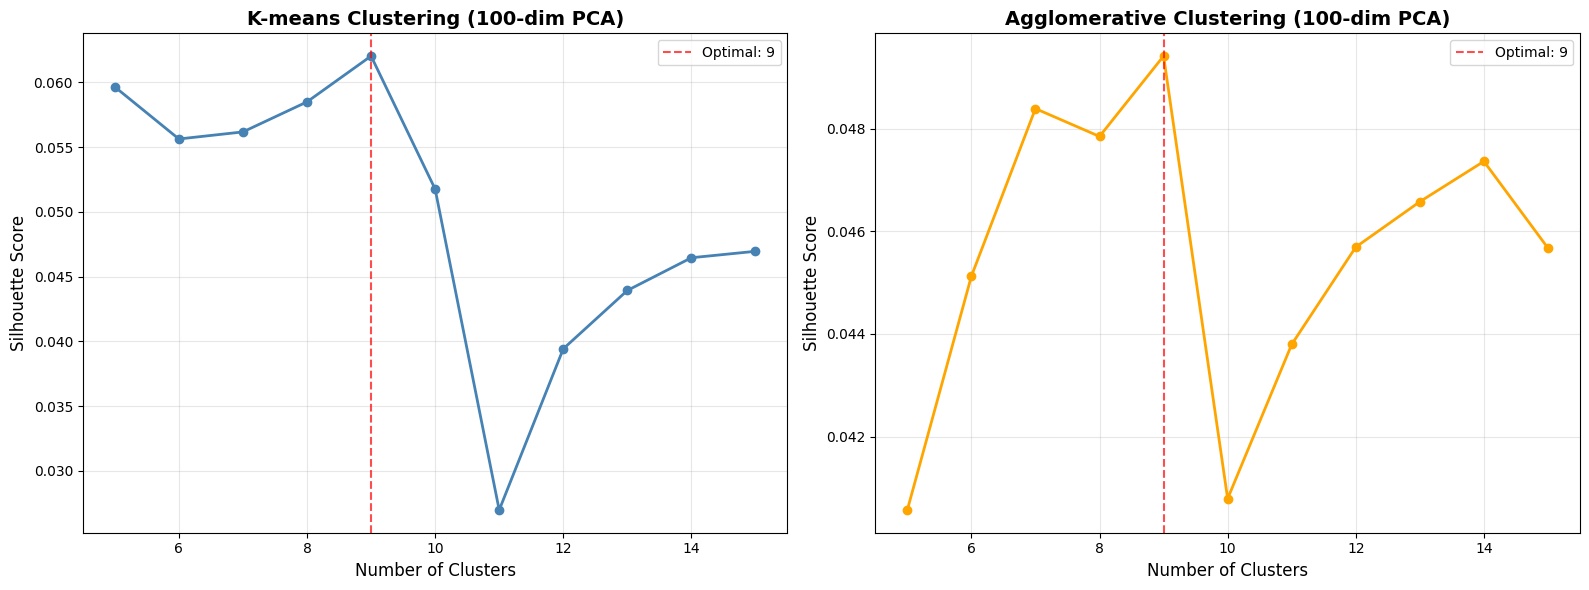

                        K-MEANS CLUSTERING (100-DIM PCA)                        

────────────────────────────────────────────────────────────────────────────────
Cluster  7 (size: 110)
────────────────────────────────────────────────────────────────────────────────
   1. 命      - life                 (freq:   3886)
   2. 菜      - vegetable            (freq:   1963)
   3. 光      - light                (freq:   2694)
   4. 水      - water                (freq:   7581)
   5. 口      - mouth                (freq:   1953)
   6. 电      - electricity          (freq:   1551)
   7. 脑      - brain                (freq:   1812)
   8. 票      - ticket               (freq:   2373)
   9. 牌      - card                 (freq:   2091)
  10. 货      - goods                (freq:   1486)

────────────────────────────────────────────────────────────────────────────────
Cluster  1 (size:  75)
────────────────────────────────────────────────────────────────────────────────
   1. 技术     - technology           (

In [20]:
# Use 100-dimension PCA embeddings (fixed)
embeddings_pca100 = pca_embeddings_dict[100]
nouns_top500 = df_noun_top2500.head(top_n)

# Grid search parameters
cluster_range = range(5, 16)  # 5 to 15 clusters

# Store results
agg_scores = []
kmeans_scores = []

for n_clusters in cluster_range:
    # Agglomerative
    agg = AgglomerativeClustering(n_clusters=n_clusters)
    agg_labels = agg.fit_predict(embeddings_pca100)
    agg_silhouette = silhouette_score(embeddings_pca100, agg_labels)
    agg_scores.append(agg_silhouette)
    
    # K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(embeddings_pca100)
    kmeans_silhouette = silhouette_score(embeddings_pca100, kmeans_labels)
    kmeans_scores.append(kmeans_silhouette)

# Find optimal number of clusters for each method
optimal_agg_idx = np.argmax(agg_scores)
optimal_agg_clusters = list(cluster_range)[optimal_agg_idx]

optimal_kmeans_idx = np.argmax(kmeans_scores)
optimal_kmeans_clusters = list(cluster_range)[optimal_kmeans_idx]

# Plot silhouette scores - side by side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# K-means plot
ax1.plot(cluster_range, kmeans_scores, marker='o', linewidth=2, markersize=6, color='steelblue')
ax1.axvline(x=optimal_kmeans_clusters, color='r', linestyle='--', alpha=0.7, 
            label=f'Optimal: {optimal_kmeans_clusters}')
ax1.set_xlabel('Number of Clusters', fontsize=12)
ax1.set_ylabel('Silhouette Score', fontsize=12)
ax1.set_title('K-means Clustering (100-dim PCA)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Agglomerative plot
ax2.plot(cluster_range, agg_scores, marker='o', linewidth=2, markersize=6, color='orange')
ax2.axvline(x=optimal_agg_clusters, color='r', linestyle='--', alpha=0.7, 
            label=f'Optimal: {optimal_agg_clusters}')
ax2.set_xlabel('Number of Clusters', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Agglomerative Clustering (100-dim PCA)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Fit optimal models
kmeans_optimal = KMeans(n_clusters=optimal_kmeans_clusters, random_state=42, n_init=10)
kmeans_optimal_labels = kmeans_optimal.fit_predict(embeddings_pca100)

agg_optimal = AgglomerativeClustering(n_clusters=optimal_agg_clusters)
agg_optimal_labels = agg_optimal.fit_predict(embeddings_pca100)

# Get top 10 words for both methods
kmeans_top10 = get_top_n_words(embeddings_pca100, kmeans_optimal_labels, nouns_top500, optimal_kmeans_clusters, n_words=10)
agg_top10 = get_top_n_words(embeddings_pca100, agg_optimal_labels, nouns_top500, optimal_agg_clusters, n_words=10)

# Display results
display_clusters(kmeans_top10, kmeans_optimal_labels, "K-MEANS CLUSTERING (100-DIM PCA)", optimal_kmeans_clusters)
print("\n\n")
display_clusters(agg_top10, agg_optimal_labels, "AGGLOMERATIVE CLUSTERING (100-DIM PCA)", optimal_agg_clusters)

---

After reducing to 100 PCA dimensions, **9 clusters produced more stable and interpretable results than 15 for the 500-word dataset.** 

At this granularity, K-means outperformed agglomerative clustering, though both methods struggled with large mixed clusters and edge cases.

---

### Top 1000

Top 1000 words - Optimal K-means clusters: 12
Top 1000 words - Optimal Agglomerative clusters: 28


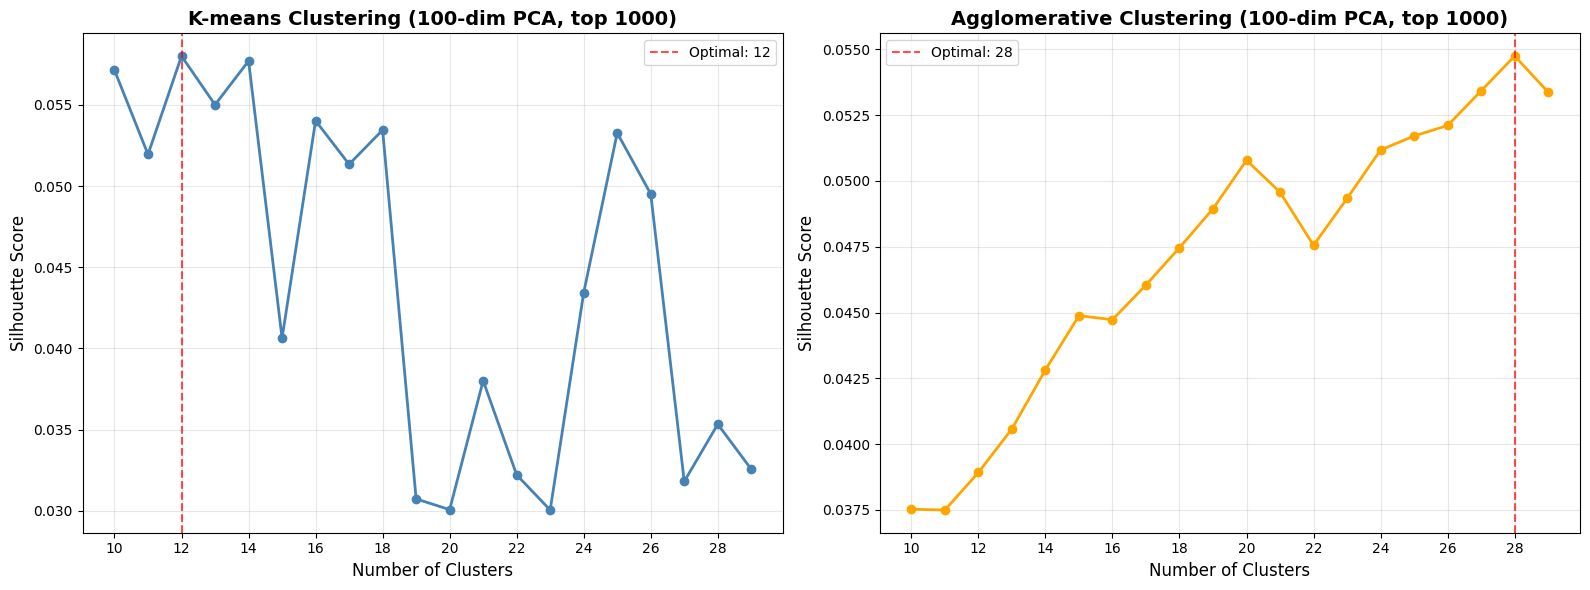

                   K-MEANS CLUSTERING (100-DIM PCA, TOP 1000)                   

────────────────────────────────────────────────────────────────────────────────
Cluster  1 (size: 176)
────────────────────────────────────────────────────────────────────────────────
   1. 菜      - vegetable            (freq:   1963)
   2. 命      - life                 (freq:   3886)
   3. 光      - light                (freq:   2694)
   4. 电      - electricity          (freq:   1551)
   5. 牌      - card                 (freq:   2091)
   6. 脑      - brain                (freq:   1812)
   7. 票      - ticket               (freq:   2373)
   8. 口      - mouth                (freq:   1953)
   9. 牙      - tooth                (freq:   1221)
  10. 货      - goods                (freq:   1486)

────────────────────────────────────────────────────────────────────────────────
Cluster 10 (size: 132)
────────────────────────────────────────────────────────────────────────────────
   1. 名单     - list                 (

In [32]:
# Use top 1000 embeddings
top_n_1000 = 1000  # Use different variable name to avoid confusion
embeddings_top1000 = embeddings[:top_n_1000]
nouns_top1000 = df_noun_top2500.head(top_n_1000)

# Apply 100-dimension PCA to top 1000 embeddings
pca_100 = PCA(n_components=100, random_state=42)
embeddings_pca100_top1000 = pca_100.fit_transform(embeddings_top1000)

# Grid search parameters
cluster_range = range(10, 30)  # 10 to 30 clusters

# Store results
agg_scores_1000 = []
kmeans_scores_1000 = []

for n_clusters in cluster_range:
    # Agglomerative
    agg = AgglomerativeClustering(n_clusters=n_clusters)
    agg_labels = agg.fit_predict(embeddings_pca100_top1000)
    agg_silhouette = silhouette_score(embeddings_pca100_top1000, agg_labels)
    agg_scores_1000.append(agg_silhouette)
    
    # K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(embeddings_pca100_top1000)
    kmeans_silhouette = silhouette_score(embeddings_pca100_top1000, kmeans_labels)
    kmeans_scores_1000.append(kmeans_silhouette)

# Find optimal number of clusters for each method (use different variable names)
optimal_agg_idx_1000 = np.argmax(agg_scores_1000)
optimal_agg_clusters_1000 = list(cluster_range)[optimal_agg_idx_1000]

optimal_kmeans_idx_1000 = np.argmax(kmeans_scores_1000)
optimal_kmeans_clusters_1000 = list(cluster_range)[optimal_kmeans_idx_1000]

print(f"Top 1000 words - Optimal K-means clusters: {optimal_kmeans_clusters_1000}")
print(f"Top 1000 words - Optimal Agglomerative clusters: {optimal_agg_clusters_1000}")

# Plot silhouette scores - side by side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# K-means plot
ax1.plot(cluster_range, kmeans_scores_1000, marker='o', linewidth=2, markersize=6, color='steelblue')
ax1.axvline(x=optimal_kmeans_clusters_1000, color='r', linestyle='--', alpha=0.7, 
            label=f'Optimal: {optimal_kmeans_clusters_1000}')
ax1.set_xlabel('Number of Clusters', fontsize=12)
ax1.set_ylabel('Silhouette Score', fontsize=12)
ax1.set_title('K-means Clustering (100-dim PCA, top 1000)', fontsize=14, fontweight='bold')
ax1.set_xticks(range(10, 30, 2))  # Show every 2nd value: 10, 12, 14, ..., 28
ax1.grid(True, alpha=0.3)
ax1.legend()

# Agglomerative plot
ax2.plot(cluster_range, agg_scores_1000, marker='o', linewidth=2, markersize=6, color='orange')
ax2.axvline(x=optimal_agg_clusters_1000, color='r', linestyle='--', alpha=0.7, 
            label=f'Optimal: {optimal_agg_clusters_1000}')
ax2.set_xlabel('Number of Clusters', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Agglomerative Clustering (100-dim PCA, top 1000)', fontsize=14, fontweight='bold')
ax2.set_xticks(range(10, 30, 2))  # Show every 2nd value: 10, 12, 14, ..., 28
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Fit optimal models
kmeans_optimal_1000 = KMeans(n_clusters=optimal_kmeans_clusters_1000, random_state=42, n_init=10)
kmeans_optimal_labels_1000 = kmeans_optimal_1000.fit_predict(embeddings_pca100_top1000)

agg_optimal_1000 = AgglomerativeClustering(n_clusters=optimal_agg_clusters_1000)
agg_optimal_labels_1000 = agg_optimal_1000.fit_predict(embeddings_pca100_top1000)

# Get top 10 words for both methods
kmeans_top10_1000 = get_top_n_words(embeddings_pca100_top1000, kmeans_optimal_labels_1000, nouns_top1000, optimal_kmeans_clusters_1000, n_words=10)
agg_top10_1000 = get_top_n_words(embeddings_pca100_top1000, agg_optimal_labels_1000, nouns_top1000, optimal_agg_clusters_1000, n_words=10)

# Display results using the fixed function
display_clusters(kmeans_top10_1000, kmeans_optimal_labels_1000, 
                 "K-MEANS CLUSTERING (100-DIM PCA, TOP 1000)", 
                 optimal_kmeans_clusters_1000)
print("\n\n")
display_clusters(agg_top10_1000, agg_optimal_labels_1000, 
                 "AGGLOMERATIVE CLUSTERING (100-DIM PCA, TOP 1000)", 
                 optimal_agg_clusters_1000)

---

**At 1000 words, both clustering methods still struggled with large, semantically heterogeneous clusters.**

K-means (k=12) consolidated around 50% of the vocabulary into four poorly-defined clusters.

Agglomerative clustering (k=28) did slightly better, limiting semantically mixed groupings to around 35% of the vocabulary across three large clusters.

---

### Top 2500

Top 2500 words - Optimal K-means clusters: 90
Top 2500 words - Optimal Agglomerative clusters: 55


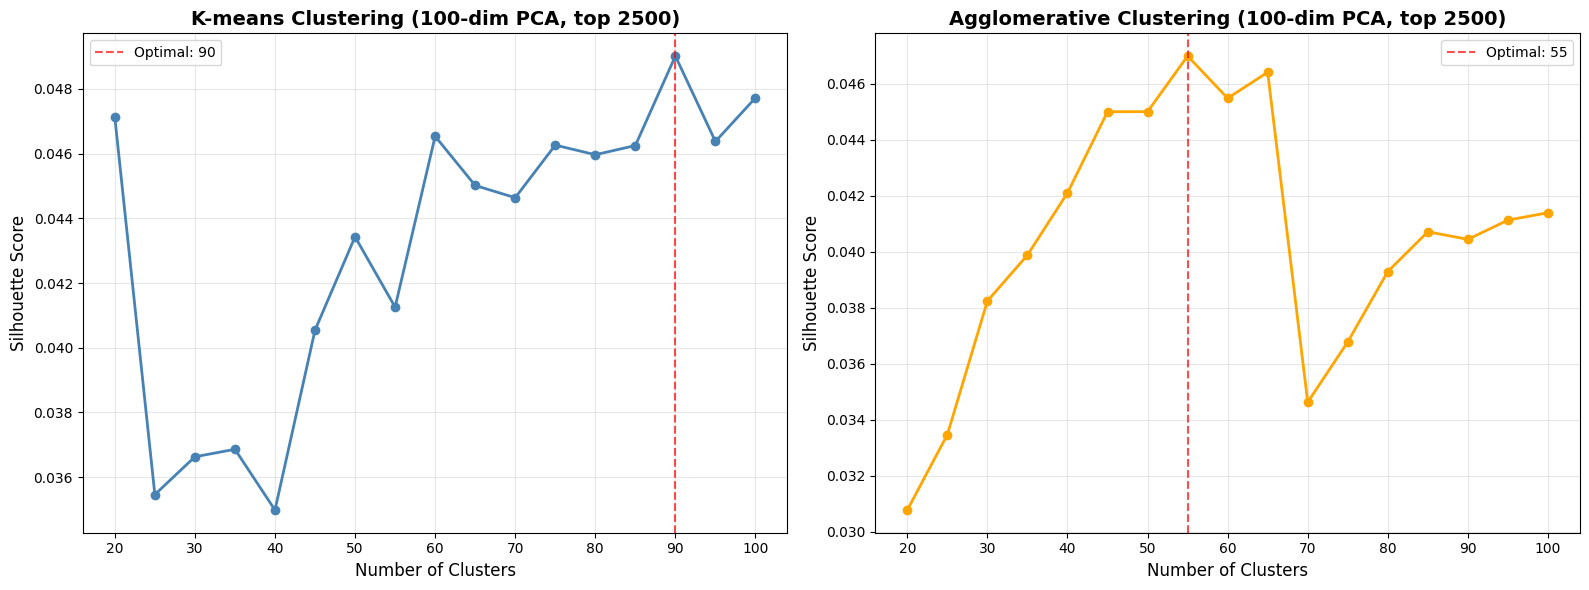

                   K-MEANS CLUSTERING (100-DIM PCA, TOP 2500)                   

────────────────────────────────────────────────────────────────────────────────
Cluster 25 (size: 115)
────────────────────────────────────────────────────────────────────────────────
   1. 款      - payment              (freq:    349)
   2. 货      - goods                (freq:   1486)
   3. 命      - life                 (freq:   3886)
   4. 料      - material             (freq:    526)
   5. 牌      - card                 (freq:   2091)
   6. 所      - place                (freq:    511)
   7. 本      - book                 (freq:   1125)
   8. 光      - light                (freq:   2694)
   9. 器      - device               (freq:    592)
  10. 人      - people               (freq: 194914)

────────────────────────────────────────────────────────────────────────────────
Cluster  0 (size:  88)
────────────────────────────────────────────────────────────────────────────────
   1. 讲话     - speech               (

In [35]:
# Use top 2500 embeddings
top_n_2500 = 2500
embeddings_top2500 = embeddings[:top_n_2500]
nouns_top2500 = df_noun_top2500.head(top_n_2500)

# Apply 100-dimension PCA to top 2500 embeddings
pca_100 = PCA(n_components=100, random_state=42)
embeddings_pca100_top2500 = pca_100.fit_transform(embeddings_top2500)

# Grid search parameters
cluster_range = range(20, 101, 5)  # 20 to 100 clusters

# Store results
agg_scores_2500 = []
kmeans_scores_2500 = []

for n_clusters in cluster_range:
    # Agglomerative
    agg = AgglomerativeClustering(n_clusters=n_clusters)
    agg_labels = agg.fit_predict(embeddings_pca100_top2500)
    agg_silhouette = silhouette_score(embeddings_pca100_top2500, agg_labels)
    agg_scores_2500.append(agg_silhouette)
    
    # K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(embeddings_pca100_top2500)
    kmeans_silhouette = silhouette_score(embeddings_pca100_top2500, kmeans_labels)
    kmeans_scores_2500.append(kmeans_silhouette)

# Find optimal number of clusters for each method
optimal_agg_idx_2500 = np.argmax(agg_scores_2500)
optimal_agg_clusters_2500 = list(cluster_range)[optimal_agg_idx_2500]

optimal_kmeans_idx_2500 = np.argmax(kmeans_scores_2500)
optimal_kmeans_clusters_2500 = list(cluster_range)[optimal_kmeans_idx_2500]

print(f"Top 2500 words - Optimal K-means clusters: {optimal_kmeans_clusters_2500}")
print(f"Top 2500 words - Optimal Agglomerative clusters: {optimal_agg_clusters_2500}")

# Plot silhouette scores - side by side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# K-means plot
ax1.plot(cluster_range, kmeans_scores_2500, marker='o', linewidth=2, markersize=6, color='steelblue')
ax1.axvline(x=optimal_kmeans_clusters_2500, color='r', linestyle='--', alpha=0.7, 
            label=f'Optimal: {optimal_kmeans_clusters_2500}')
ax1.set_xlabel('Number of Clusters', fontsize=12)
ax1.set_ylabel('Silhouette Score', fontsize=12)
ax1.set_title('K-means Clustering (100-dim PCA, top 2500)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Agglomerative plot
ax2.plot(cluster_range, agg_scores_2500, marker='o', linewidth=2, markersize=6, color='orange')
ax2.axvline(x=optimal_agg_clusters_2500, color='r', linestyle='--', alpha=0.7, 
            label=f'Optimal: {optimal_agg_clusters_2500}')
ax2.set_xlabel('Number of Clusters', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Agglomerative Clustering (100-dim PCA, top 2500)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Fit optimal models
kmeans_optimal_2500 = KMeans(n_clusters=optimal_kmeans_clusters_2500, random_state=42, n_init=10)
kmeans_optimal_labels_2500 = kmeans_optimal_2500.fit_predict(embeddings_pca100_top2500)

agg_optimal_2500 = AgglomerativeClustering(n_clusters=optimal_agg_clusters_2500)
agg_optimal_labels_2500 = agg_optimal_2500.fit_predict(embeddings_pca100_top2500)

# Get top 10 words for both methods
kmeans_top10_2500 = get_top_n_words(embeddings_pca100_top2500, kmeans_optimal_labels_2500, nouns_top2500, optimal_kmeans_clusters_2500, n_words=10)
agg_top10_2500 = get_top_n_words(embeddings_pca100_top2500, agg_optimal_labels_2500, nouns_top2500, optimal_agg_clusters_2500, n_words=10)

# Display results
display_clusters(kmeans_top10_2500, kmeans_optimal_labels_2500, 
                 "K-MEANS CLUSTERING (100-DIM PCA, TOP 2500)", 
                 optimal_kmeans_clusters_2500)
print("\n\n")
display_clusters(agg_top10_2500, agg_optimal_labels_2500, 
                 "AGGLOMERATIVE CLUSTERING (100-DIM PCA, TOP 2500)", 
                 optimal_agg_clusters_2500)

---

At 2500 words, K-means unexpectedly discovered 90 fine-grained clusters versus agglomerative's 55, and both achieved similar overall semantic coherence.

However, **15-25% of the vocabulary remained in large, semantically mixed clusters.**

These heterogenous clusters warrant further investigation, as they likely represent words that are coherent along a different set of dimensions.

---